# LSTM-Based Sentiment Analysis on IMDB Movie Reviews

This project implements a bidirectional LSTM neural network for sentiment analysis on movie reviews using the IMDB dataset.

## Project Overview

This project demonstrates **natural language processing (NLP)** and **sentiment classification** using deep learning techniques, specifically focusing on Long Short-Term Memory (LSTM) networks for sequence modeling.

### **Dataset**: IMDB Movie Reviews
- **Size**: 50,000 movie reviews (25,000 train + 25,000 test)
- **Classes**: 2 (Positive and Negative sentiment)
- **Task**: Binary sentiment classification
- **Text Length**: Up to 256 tokens per review (truncated)
- **Challenge**: Variable-length sequences and complex language patterns

### **Model Architecture**: Bidirectional LSTM
- **Embedding Layer**: 300-dimensional word embeddings
- **LSTM Encoder**: 2-layer bidirectional LSTM (300 hidden units each direction)
- **Architecture Flow**: 
  - Token IDs → Embeddings → Packed Sequences → Bi-LSTM → Sentence Vector → Classification
- **Output**: Binary classification logits (Positive/Negative)
- **Parameters**: ~10.1M trainable parameters

### **Key Features**:

#### **1. Advanced Text Processing**
- **Tokenization**: Basic English tokenizer with punctuation handling
- **Vocabulary Building**: Custom vocabulary from training data with UNK/PAD tokens
- **Sequence Packing**: Efficient handling of variable-length sequences
- **Padding Strategy**: Dynamic padding with attention to actual sequence lengths

#### **2. Sophisticated Model Design**
- **Bidirectional Processing**: Captures context from both directions
- **Packed Sequences**: Ignores padding tokens during LSTM processing
- **Dropout Regularization**: 0.5 dropout rate to prevent overfitting
- **Weight Initialization**: Xavier normal for linear layers, orthogonal for LSTM weights

#### **3. Training and Optimization**
- **Loss Function**: Cross-entropy loss for binary classification
- **Optimizer**: Adam optimizer with learning rate scheduling
- **Evaluation Metrics**: Accuracy, precision, recall, F1-score
- **Validation**: Proper train/validation split for model selection

#### **4. Technical Implementation**
- **Framework**: PyTorch with torchtext for NLP utilities
- **Batching**: Efficient DataLoader with collate functions
- **Memory Management**: Packed sequences for variable-length handling
- **Reproducibility**: Fixed random seeds for consistent results

### **Expected Outcomes**:
- **Performance**: High accuracy on sentiment classification (>85%)
- **Generalization**: Robust performance on unseen movie reviews
- **Efficiency**: Fast inference through optimized sequence processing
- **Interpretability**: Analysis of model predictions and learned representations

### **Technical Highlights**:
- **Dynamic Padding**: Efficient memory usage with sequence packing
- **Bidirectional Context**: Enhanced representation through forward/backward processing
- **Modern NLP Pipeline**: Complete preprocessing, training, and evaluation workflow
- **Scalable Architecture**: Easily adaptable to other text classification tasks

---

## Implementation Details

### Environment Setup

This project uses PyTorch with torchtext for NLP utilities. Ensure you have compatible versions installed for optimal performance.

In [ ]:
# Required packages installation (run if needed)
# %pip install torch torchvision torchaudio
# %pip install torchtext datasets

In [1]:
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext
import tqdm

C:\Users\INK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [67]:
# ================================================================
# 1. Download IMDB movie‑review dataset
# ‑ 25 000 positive + 25 000 negative reviews
# ‑ Provided in "train" / "test" splits by default
# ================================================================
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

In [81]:
tokenizer = get_tokenizer("basic_english") # simple white‑space / punctuation

In [ ]:
# Tokenization helper function
# tokenize_example() takes a raw example dict from datasets
# and returns tokens + their length, capped at max_length
def tokenize_example(example, tokenizer, max_length): # truncate long reviews
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

In [ ]:
max_length = 256 # max length of review

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map: 100%|██████████| 25000/25000 [00:03<00:00, 7631.77 examples/s]


In [ ]:
# ================================================================
# 3. Split Train → Train / Valid (25 % valid)
# ================================================================
test_size = 0.25 

train_valid_data = train_data.train_test_split(test_size=test_size) 
train_data = train_valid_data["train"] 
valid_data = train_valid_data["test"] 

In [ ]:
# ================================================================
# 4. Build Vocabulary
# ------------------------------------------------
#  • min_freq = 5    → drop ultra‑rare words
#  • specials        → add <unk> AND <pad>
# ================================================================
min_freq = 5 # drop ultra‑rare words
special_tokens = ["<unk>", "<pad>"]

vocab = build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [9]:
unk_index = vocab["<unk>"]  
pad_index = vocab["<pad>"] 

In [10]:
vocab.set_default_index(unk_index) # unknown words are replaced by <unk> token

In [11]:
# ================================================================
# 5. Numericalise tokens → integer IDs
# ------------------------------------------------
# (map across all splits)
# ================================================================
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [12]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map: 100%|██████████| 25000/25000 [00:06<00:00, 4120.10 examples/s]


In [13]:
# ================================================================
# 6. Convert dataset columns to PyTorch tensors (lazy)
# ------------------------------------------------
# Each example keeps: ids (LongTensor), label (int64), length (int64)
# ================================================================
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [18]:
sample = train_data.with_format("python")[0]      # temporary switch
print(sample["tokens"][:15], sample["label"])
train_data = train_data.with_format(              # switch back
    type="torch", columns=["ids", "label", "length"]
)

['look', ',', 'this', 'is', 'quite', 'possibly', 'one', 'of', 'the', 'best', 'movies', 'america', 'has', 'to', 'offer'] 1


In [21]:
# ================================================================
# 7. DataLoader with padding
# ------------------------------------------------
# get_collate_fn() handles:
#  • pad_sequence() to align variable‑length batches
#  • stack() the length / label tensors
# ================================================================
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [22]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [23]:
batch_size = 256

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [ ]:
# Bidirectional LSTM Model for Sentiment Classification

# ================================================================
# 8. BI‑LSTM  Model for Sentence Classification
# ------------------------------------------------
# • Embedding   → pack_padded_sequence() → LSTM
# • Use final hidden state(s) of last layer as sentence vector
# • Dropout then Linear for 2‑class logits
# ================================================================
class LSTM(nn.Module):
    """
    Bi‑directional LSTM based sentence classifier.

    Input  : padded IDs   (B, T)
    Output : logits       (B, C)
    """
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        output_dim: int,
        n_layers: int,
        bidirectional: bool,
        dropout_rate: float,
        pad_index: int,
    ):
        super().__init__()

        # --- 1. Token IDs → vectors -----------------------------------------
        self.embedding = nn.Embedding(
            num_embeddings = vocab_size,
            embedding_dim  = embedding_dim,
            padding_idx    = pad_index,      # padded positions are zeros
        )

        # --- 2. LSTM encoder -------------------------------------------------
        self.encoder = nn.LSTM(
            input_size   = embedding_dim,
            hidden_size  = hidden_dim,
            num_layers   = n_layers,
            bidirectional= bidirectional,
            batch_first  = True,             # (B, T, E)
            dropout      = dropout_rate if n_layers > 1 else 0.0,
        )

        # --- 3. Classifier head ---------------------------------------------
        direction_mult = 2 if bidirectional else 1
        self.dropout = nn.Dropout(dropout_rate)
        self.fc      = nn.Linear(hidden_dim * direction_mult, output_dim)

    def forward(self, ids: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        """
        ids     : LongTensor (B, T)
        lengths : LongTensor (B,)  – true lengths (CPU acceptable)
        return  : logits      (B, C)
        """
        # (B, T) -> (B, T, E)
        embedded = self.embedding(ids)

        # Tell LSTM to ignore <pad> tokens via packed sequences
        packed_emb = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, (hidden, _) = self.encoder(packed_emb)
        # hidden shape: (num_layers * num_directions, B, H)

        # Grab last layer's hidden state(s)
        if self.encoder.bidirectional:
            # Concatenate last forward & backward hidden states
            sentence_vec = torch.cat((hidden[-2], hidden[-1]), dim=1)  # (B, 2H)
        else:
            sentence_vec = hidden[-1]                                  # (B, H)

        outputs = self.dropout(sentence_vec)
        logits  = self.fc(outputs)
        return logits



In [25]:
# ---------------------------------------------------------------
# Model hyper‑parameters (can be tweaked)
# ---------------------------------------------------------------
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [26]:
# Utility: count only trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 10,101,302 trainable parameters


In [ ]:
# ================================================================
# 9. Weight Initialization
# ------------------------------------------------
#  • Linear  → Xavier (Glorot) + zero bias
#  • LSTM    → orthogonal recurrent weights, zero biases
# ================================================================
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [28]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(21635, 300, padding_idx=1)
  (encoder): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=600, out_features=2, bias=True)
)

In [ ]:
# ================================================================
# 10. Load pretrained GloVe embeddings
# ------------------------------------------------
#  • torchtext's GloVe 2 × 300d vectors (~822 MB on first download)
#  • Replace the random embedding matrix with pretrained weights
#  • OOV words keep random init (because vocab.set_default_index already handled)
# ================================================================
vectors = torchtext.vocab.GloVe()

.vector_cache\glove.840B.300d.zip: 2.18GB [28:01, 1.29MB/s]                               
100%|█████████▉| 2196016/2196017 [02:19<00:00, 15699.83it/s]


In [30]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [31]:
model.embedding.weight.data = pretrained_embedding

In [ ]:
# ================================================================
# 11. Optimizer + Loss
# ================================================================
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [33]:
criterion = nn.CrossEntropyLoss()

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [39]:
# ================================================================
# 12. Move model & criterion to GPU (if available)
# ================================================================
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# ================================================================
# 13. Training / Evaluation Loops
# ================================================================
def train(dataloader, model, criterion, optimizer, device):
    """
    prediction : logits (B, C)
    label      : ground‑truth class (B,)
    returns    : scalar tensor accuracy
    """
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [37]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [38]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [68]:
# ================================================================
# 14. Main training loop (save best model by valid loss)
# ================================================================
n_epochs = 3 # because of my hardware conditions, I set it to 3 epochs instead of 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 25/25 [00:47<00:00,  1.91s/it]


epoch: 0
train_loss: 0.430, train_acc: 0.811
valid_loss: 0.400, valid_acc: 0.820


evaluating...: 100%|██████████| 25/25 [00:47<00:00,  1.90s/it]


epoch: 1
train_loss: 0.440, train_acc: 0.799
valid_loss: 0.351, valid_acc: 0.843


evaluating...: 100%|██████████| 25/25 [00:48<00:00,  1.94s/it]

epoch: 2
train_loss: 0.281, train_acc: 0.887
valid_loss: 0.320, valid_acc: 0.864


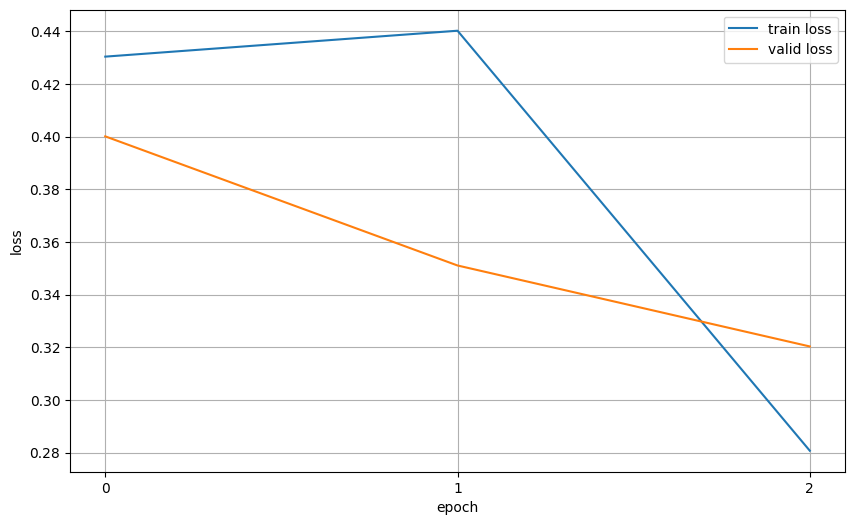

In [69]:
# ================================================================
# 15. Plot learning curves
# ================================================================
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

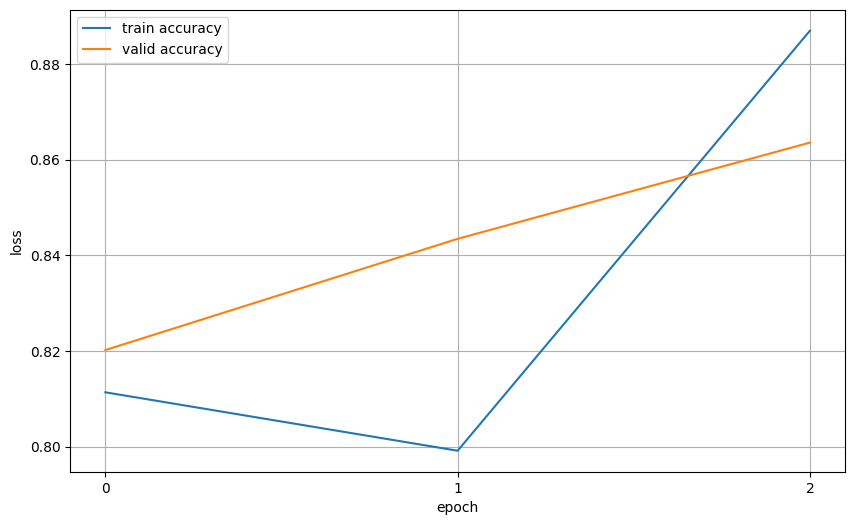

In [70]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [71]:
# ================================================================
# 16. Test‑set evaluation (load best checkpoint)
# ================================================================
model.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 98/98 [03:10<00:00,  1.95s/it]


In [72]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.335, test_acc: 0.854


In [75]:
# ================================================================
# 17. Convenience function: predict sentiment for a raw string
# ================================================================
def predict_sentiment(text, model, tokenizer, vocab, device):
    """
    Returns predicted class (0 = neg, 1 = pos) and its probability.
    """
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [82]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9369540810585022)

In [83]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.881648600101471)

In [84]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.6538264751434326)

In [86]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.779675304889679)